# Mod 4 Project - Starter Notebook
This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset.

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing.

NOTE: The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting
This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project.

# Wide Format vs Long Format
If you take a look at the format of the data in zillow_data.csv, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample:


You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called Wide Format, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to Long Format. Reshaped into long format, the dataframe above would now look like:


There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is pd.melt(), and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format.

# Helper Functions Provided
Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, melt_data(), to help you with this step below. Also provided is:

- get_datetimes(), a function to deal with converting the column values for datetimes as a pandas series of datetime objects
- Some good parameters for matplotlib to help make your visualizations more readable.
Good luck!

Step 1: Load the Data/Filtering for Chosen Zipcodes
Time Series analysis
Business Understanding
Objectives
- Find the top ZipCodes.
- Develop a Time-Series regression model to predict house prices for the next 6 months.
- Investigate change of house prices in the top ten States with the most high priced houses.

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt



In [122]:
df = pd.read_csv('./zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [123]:
df.tail()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400
14722,95851,89155,Mesquite,NV,Las Vegas,Clark,14723,176400.0,176300.0,176100.0,...,333800,336400,339700,343800,346800,348900,350400,353000,356000,357200


In [124]:
df.duplicated().sum()

0

In [125]:
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [127]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [128]:
melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
melted.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,91982,3,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,84616,4,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,93144,5,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [129]:
melted.isna().sum()

RegionName         0
RegionID           0
SizeRank           0
City               0
State              0
Metro         276395
CountyName         0
time               0
value         156891
dtype: int64

In [130]:
melted.shape

(3901595, 9)

In [131]:
melted.columns

Index(['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro',
       'CountyName', 'time', 'value'],
      dtype='object')

In [132]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901595 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionName  int64         
 1   RegionID    int64         
 2   SizeRank    int64         
 3   City        object        
 4   State       object        
 5   Metro       object        
 6   CountyName  object        
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 267.9+ MB


In [133]:
melted.describe()

,RegionName,RegionID,SizeRank,value
count,3.901595e+06,3.901595e+06,3.901595e+06,3.744704e+06
mean,4.822235e+04,8.107501e+04,7.362000e+03,2.076064e+05
std,2.935833e+04,3.193304e+04,4.250165e+03,2.400207e+05
min,1.001000e+03,5.819600e+04,1.000000e+00,1.130000e+04
25%,2.210100e+04,6.717400e+04,3.681000e+03,9.790000e+04
50%,4.610600e+04,7.800700e+04,7.362000e+03,1.476000e+05
75%,7.520600e+04,9.092100e+04,1.104300e+04,2.372000e+05
max,9.990100e+04,7.538440e+05,1.472300e+04,1.931490e+07


<AxesSubplot: ylabel='count'>

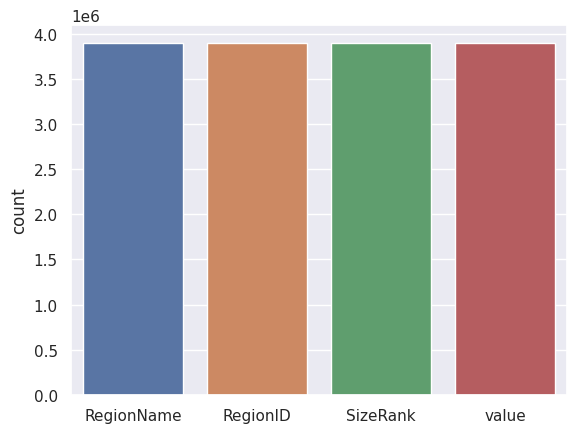

In [134]:
sns.countplot(melted)

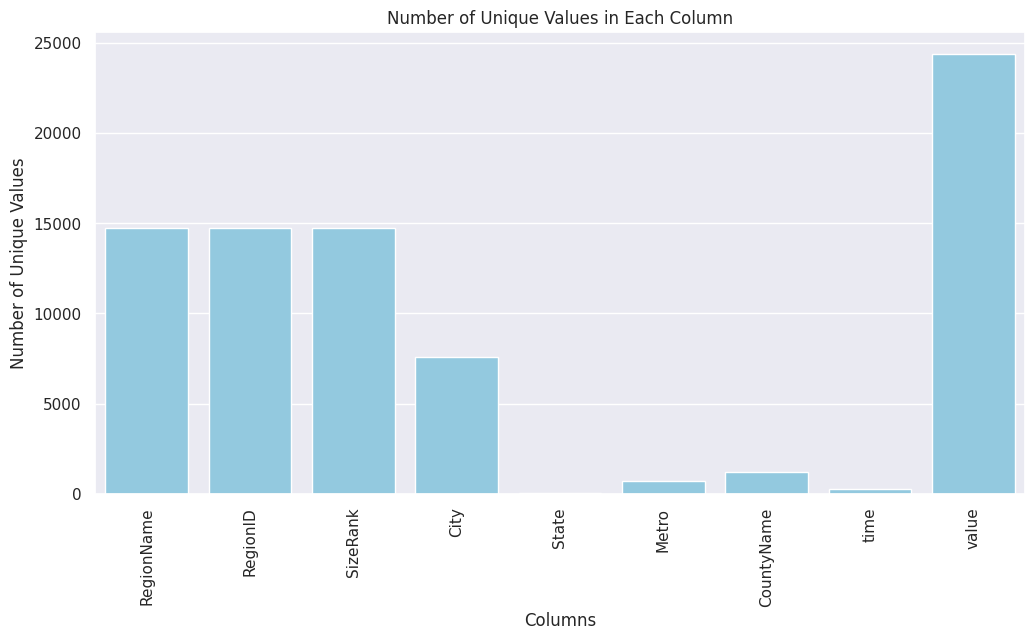

In [135]:
unique_values = melted.nunique()

# Create a bar plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=unique_values.index, y=unique_values.values, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Values in Each Column')
plt.show()


In [136]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [137]:
new_df = melt_data(df)
new_df.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


In [138]:
new_df.tail()

,value
time,
2017-12-01,281095.320247
2018-01-01,282657.060382
2018-02-01,284368.688447
2018-03-01,286511.376757
2018-04-01,288039.944305


In [139]:
new_df.to_excel('output_2.xlsx')

In [140]:
new_df.isna().sum()

value    0
dtype: int64

In [141]:
new_df.duplicated().sum()

0

In [142]:
new_df.describe()

,value
count,265.000000
mean,206661.505593
std,47809.380643
min,118299.123063
25%,168653.357200
50%,215113.127917
75%,245934.664560
max,288039.944305


<AxesSubplot: xlabel='time'>

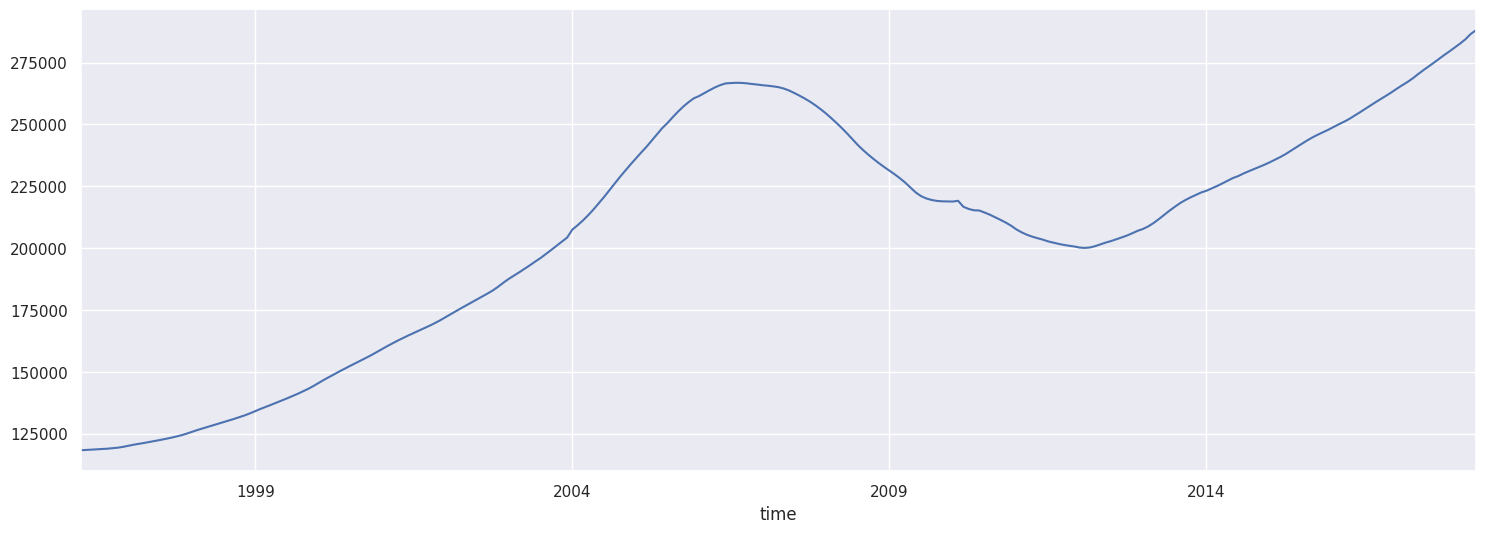

In [143]:
new_df['value'].plot(figsize=(18, 6))

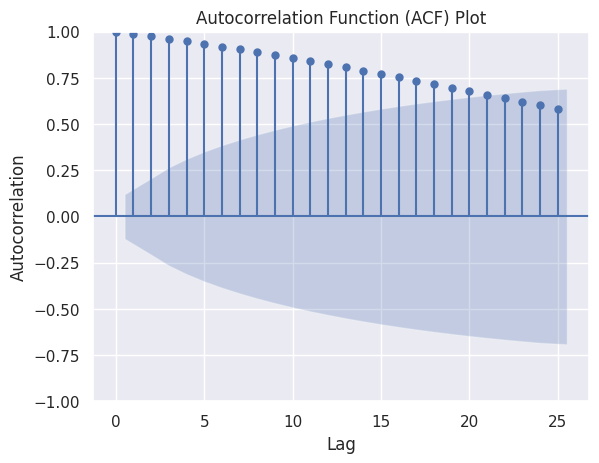

In [144]:
# checking for stationarity
plot_acf(new_df['value'])
plt.title('Autocorrelation Function (ACF) Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

### we should use a higher value of q since the acf plot is decaying slowly

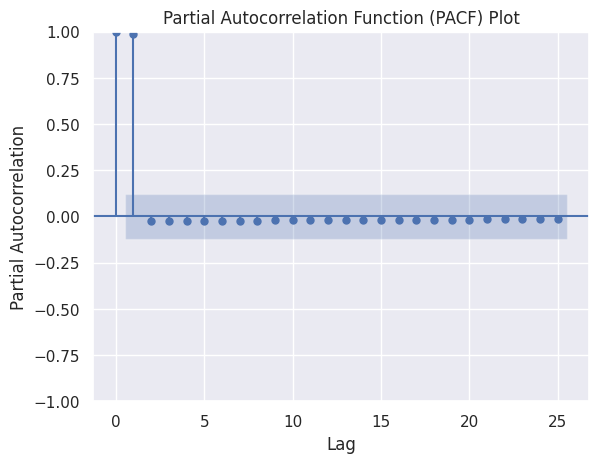

In [145]:
sm.graphics.tsa.plot_pacf(new_df['value'])
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

### The high spikes at lags 1 and 2 suggest a strong autocorrelation at these lags, consider including autoregressive terms in your time series model, particularly AR(1) and AR(2) terms.

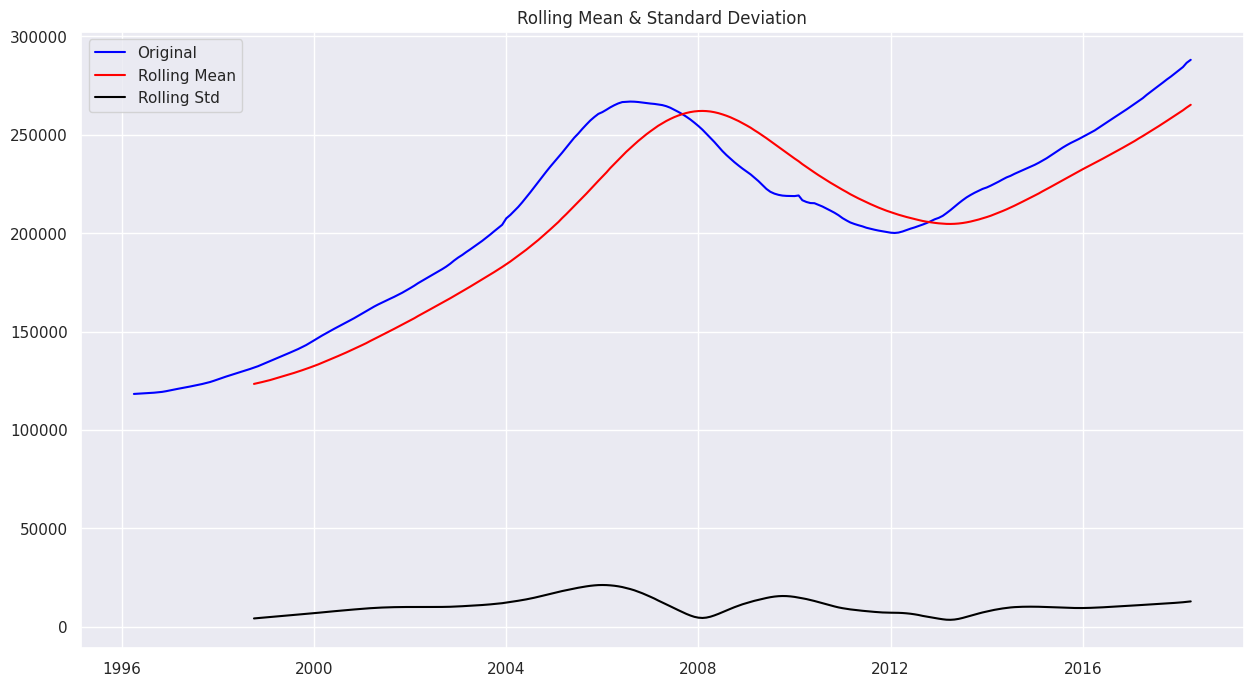

Results of Dickey-Fuller Test:
Test Statistic                  -1.885145
p-value                          0.339082
#Lags Used                       2.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


In [146]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=31).mean()  # Slide window depend on past 1 month
    rolstd = timeseries.rolling(window=31).std()

    # Plot rolling statistics:
    plt.figure(figsize=(15, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Applying the function to your time series
test_stationarity(new_df['value'])


# The p-value is greater than commonly used significance levels "0.05". Therefore, you fail to reject the null hypothesis. This suggests that there is not enough evidence to conclude that the time series is stationary.

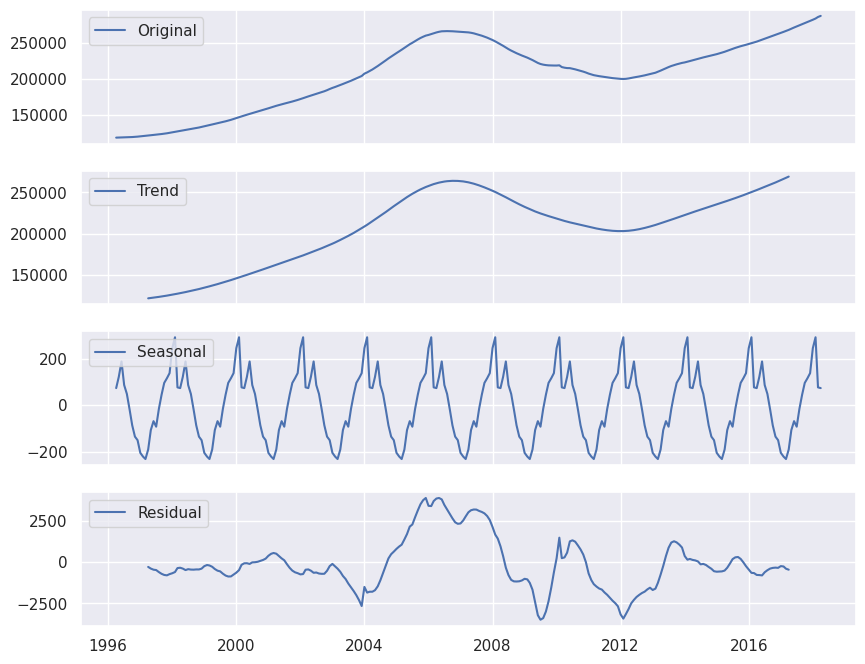

In [147]:
# Perform seasonal decomposition
result = sm.tsa.seasonal_decompose(new_df['value'], model='additive', period=24)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

ax1.plot(new_df['value'], label='Original')
ax1.legend(loc='upper left')

ax2.plot(result.trend, label='Trend')
ax2.legend(loc='upper left')

ax3.plot(result.seasonal, label='Seasonal')
ax3.legend(loc='upper left')

ax4.plot(result.resid, label='Residual')
ax4.legend(loc='upper left')

plt.show()


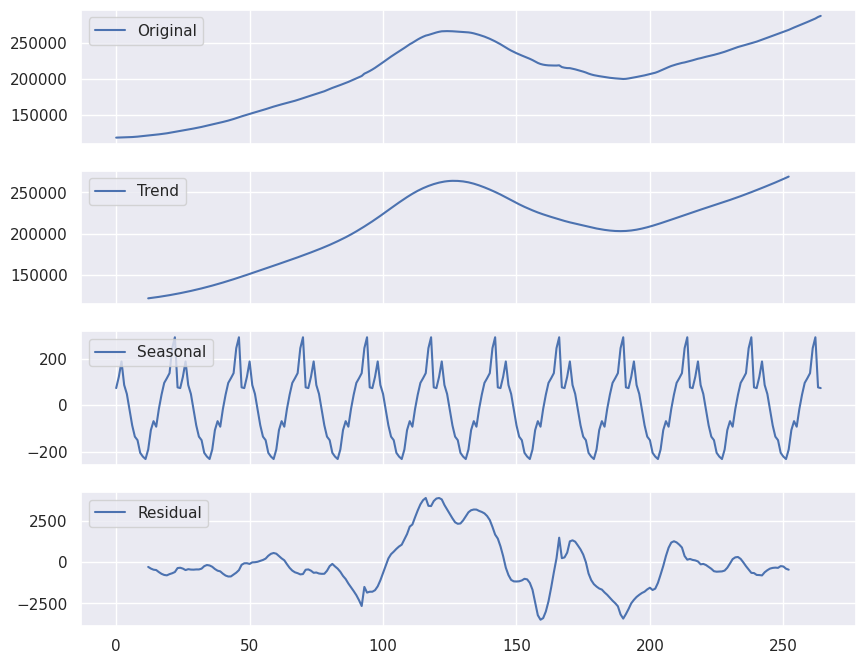

In [148]:
new_df = pd.read_excel('./output_2.xlsx')

# Perform seasonal decomposition
result = sm.tsa.seasonal_decompose(new_df['value'], model='additive', period=24)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

ax1.plot(new_df['value'], label='Original')
ax1.legend(loc='upper left')

ax2.plot(result.trend, label='Trend')
ax2.legend(loc='upper left')

ax3.plot(result.seasonal, label='Seasonal')
ax3.legend(loc='upper left')

ax4.plot(result.resid, label='Residual')
ax4.legend(loc='upper left')

plt.show()




In [149]:
# Remove Seasonality
deseasonalized_data = new_df['value'] - result.seasonal

# Deseasonalize Data
# Subtract the seasonal component from the original series
deseasonalized_df = pd.DataFrame({
    'date': new_df['time'],  # Adjust column names accordingly
    'deseasonalized_value': deseasonalized_data
})

# Identify Trend
# Analyze the trend component to understand the overall direction
trend_series = result.trend

# Residual Analysis
# Examine the residual component for any remaining patterns or irregularities
residual_series = result.resid

In [150]:
# Baseline model
order = (1, 1, 0)  # Adjust order based on your analysis

arima_model = sm.tsa.ARIMA(new_df['value'], order=order)
arima_results = arima_model.fit()

# Generate forecasts
forecast_values = arima_results.predict(start=len(new_df), end=len(new_df) + 10, dynamic=False)


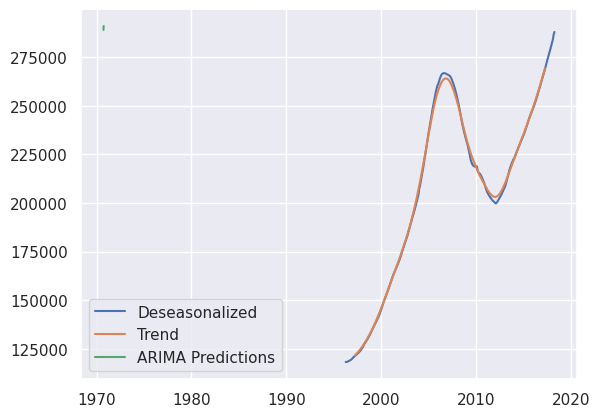

In [160]:
import statsmodels.api as sm

deseasonalized_df['time'] = pd.to_datetime(deseasonalized_df['date'])

# Fit ARIMA model
order = (1,1,0)  # Choose appropriate values for p, d, q
arima_model = sm.tsa.ARIMA(deseasonalized_df['deseasonalized_value'], order=order)
arima_results = arima_model.fit()

# Make predictions
forecast_steps = 10  # Adjust as needed
predictions = arima_results.get_forecast(steps=forecast_steps)

# Plot the original series, trend, and predictions
plt.plot(deseasonalized_df['time'], deseasonalized_df['deseasonalized_value'], label='Deseasonalized')
plt.plot(deseasonalized_df['time'], result.trend, label='Trend')
plt.plot(predictions.predicted_mean.index, predictions.predicted_mean, label='ARIMA Predictions')
plt.legend()
plt.show()


In [153]:
new_df['time'] = pd.to_datetime(new_df['time'])
data = new_df.rename(columns={'time': 'ds', 'value': 'y'})

In [154]:
model = Prophet()
model.fit(data)


15:52:25 - cmdstanpy - INFO - Chain [1] start processing


15:52:25 - cmdstanpy - INFO - Chain [1] done processing


In [155]:
future = model.make_future_dataframe(periods=365)  # Adjust the number of periods as needed
forecast = model.predict(future)


In [156]:
future = model.make_future_dataframe(periods=100,freq='D')
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1996-04-01,117278.055683,116062.619296,118581.170727,117278.055683,117278.055683,46.403551,46.403551,46.403551,46.403551,46.403551,46.403551,0.0,0.0,0.0,117324.459234
1,1996-05-01,117613.698754,116498.524537,118874.617981,117613.698754,117613.698754,79.064392,79.064392,79.064392,79.064392,79.064392,79.064392,0.0,0.0,0.0,117692.763146
2,1996-06-01,117960.529927,116855.280137,119338.571175,117960.529927,117960.529927,136.381769,136.381769,136.381769,136.381769,136.381769,136.381769,0.0,0.0,0.0,118096.911697
3,1996-07-01,118296.172998,117138.078219,119577.252741,118296.172998,118296.172998,98.188499,98.188499,98.188499,98.188499,98.188499,98.188499,0.0,0.0,0.0,118394.361498
4,1996-08-01,118643.004172,117466.172501,119875.798510,118643.004172,118643.004172,81.866934,81.866934,81.866934,81.866934,81.866934,81.866934,0.0,0.0,0.0,118724.871105


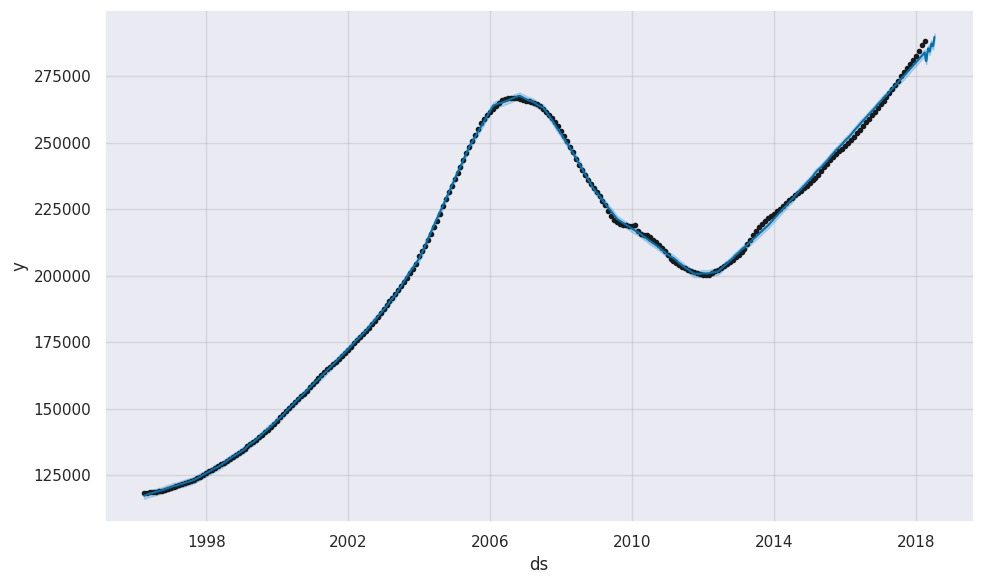

In [157]:
fig = model.plot(forecast)


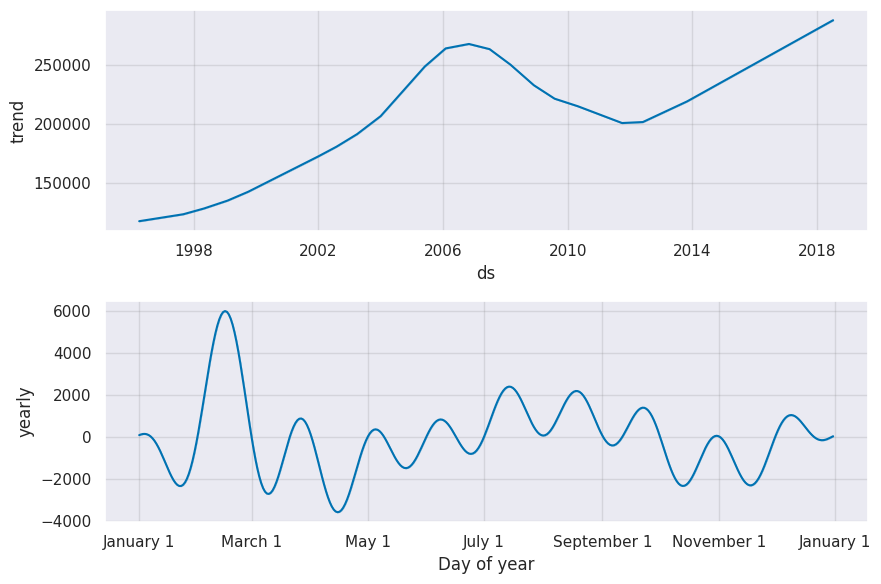

In [158]:
plt2 = model.plot_components(forecast)
